In [44]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3,
                     "axes.grid": True,
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})

USE_TEX = False
if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [45]:
from SALib.sample import sobol
from tqdm import tqdm

from network_model import *
import time

from scipy.optimize import minimize

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [47]:
# define problem
PROBLEM = {
    "num_vars" : 3,
    "names"    : ["wealth", "return", "a"],
    "bounds"   : [[0.0, 10],
                  [1.0, 1.3],
                  [0.1, 0.5]]
}

# generate Saltelli samples
NUM_SAMPLES = 4096
X = sobol.sample(PROBLEM, NUM_SAMPLES)

In [19]:
def isoelastic(x, eta=1.5):
    return x**(1-eta) / (1-eta)

In [20]:
def iso_util(x, w, investment_returns, eta, scale):
     return - (isoelastic(w*x, eta) + isoelastic(sum(w*(1-x)*investment_returns), eta*scale))

In [50]:
# prepare dataset
consumption = {}
for row in tqdm(X):
    c = minimize(utility, x0=0.5, bounds=[(0.01, 0.99)], args=(row[0], row[1], row[2], 2.1)).x[0]
    consumption[tuple(row)] = c
    
with open("response_surface_data.pickle", "wb") as f:
    pickle.dump(consumption, f)

X = np.row_stack(list(consumption.keys()))
y = np.array(list(consumption.values()))

100%|██████████| 32768/32768 [00:55<00:00, 590.88it/s]


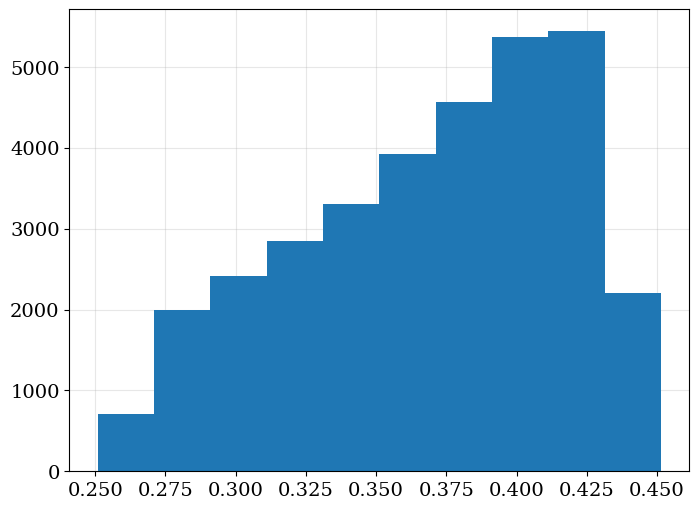

In [51]:
plt.hist(y)
plt.show()

# Grid Search

In [15]:
rfr = RandomForestRegressor(n_jobs=4)

parameters = {
    "n_estimators":[100,250],
    "max_depth":[16,32,None],
}

In [16]:
cv = GridSearchCV(rfr,parameters, cv=5, verbose=3)
cv.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ....max_depth=16, n_estimators=100;, score=0.980 total time=  10.0s
[CV 2/5] END ....max_depth=16, n_estimators=100;, score=0.995 total time=   8.9s
[CV 3/5] END ....max_depth=16, n_estimators=100;, score=0.996 total time=   8.5s
[CV 4/5] END ....max_depth=16, n_estimators=100;, score=0.994 total time=   9.0s
[CV 5/5] END ....max_depth=16, n_estimators=100;, score=0.988 total time=   8.7s
[CV 1/5] END ....max_depth=16, n_estimators=250;, score=0.979 total time=  21.6s
[CV 2/5] END ....max_depth=16, n_estimators=250;, score=0.995 total time=  21.4s
[CV 3/5] END ....max_depth=16, n_estimators=250;, score=0.996 total time=  24.1s
[CV 4/5] END ....max_depth=16, n_estimators=250;, score=0.994 total time=  27.3s
[CV 5/5] END ....max_depth=16, n_estimators=250;, score=0.988 total time=  24.0s
[CV 1/5] END ....max_depth=32, n_estimators=100;, score=0.981 total time=  10.0s
[CV 2/5] END ....max_depth=32, n_estimators=100;,

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=4),
             param_grid={'max_depth': [16, 32, None],
                         'n_estimators': [100, 250]},
             verbose=3)

In [ ]:
print(cv.best_params_)
print(cv.best_score_)

with open("rfr.pickle", "wb") as f:
    pickle.dump(cv.best_estimator_, f)

In [52]:
rfr = RandomForestRegressor(n_jobs=4, max_depth=None, n_estimators=250)

In [53]:
rfr.fit(X,y)

RandomForestRegressor(n_estimators=250, n_jobs=4)

3.030632256312642e-05 0.0002892580200198891
0


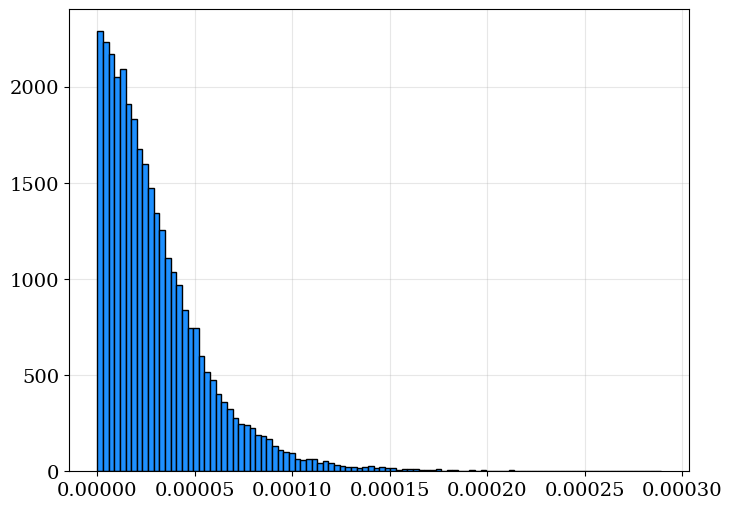

In [54]:
preds = rfr.predict(X)
delta = np.abs(preds - y)
print(np.mean(delta), np.max(delta))
print(len([x for x in delta if x > 0.05]))

plt.hist(delta, bins=100, color="dodgerblue", edgecolor='k')
plt.show()

In [70]:
with open("rfr.pickle", "wb") as f:
    pickle.dump(rfr, f)

## Some unit testing

In [392]:
["wealth", "return", "a"]

['wealth', 'return', 'a', 'gamma']

In [72]:
x = (0.7, 1.1, 0.02, 2.1)

print(f"Actual    : {minimize(utility, x0=0.5, bounds=[(0.05, 0.95)], args=(x)).x[0]:.5f}")
print(f"Predicted : {rfr.predict(np.array(x[:-1]).reshape(1,3))[0]:.5f}")

Actual    : 0.14028
Predicted : 0.26037


In [36]:
from scipy.spatial import KDTree

In [37]:
tree = KDTree(X)

In [38]:
tree.query(np.array((0.7, 0.078, 1.4, 1.2)))

(0.9388342019893609, 3271)

In [39]:
X[3271]

array([0.60805041, 1.00875108, 1.43308939, 1.12541818])

In [40]:
y[3271]

0.46573125021514805